In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import requests
from io import BytesIO

In [30]:
IMAGE_URL = "https://www.google.com/imgres?q=images%20for%20vqa%20sample&imgurl=https%3A%2F%2Fvictorzhou.com%2Fstatic%2F5039afcd70dc9b7daa858da7aed6423c%2Fbbe0c%2Fbaseball.jpg&imgrefurl=https%3A%2F%2Fvictorzhou.com%2Fblog%2Feasy-vqa%2F&docid=crgIYqOd3qwG6M&tbnid=Nesy9d4nYGS4XM&vet=12ahUKEwjOyvjdqc6QAxVpka8BHa2pLccQM3oECBYQAA..i&w=640&h=427&hcb=2&ved=2ahUKEwjOyvjdqc6QAxVpka8BHa2pLccQM3oECBYQAA"

QUESTIONS = [
    "which sport is depicted",
    "which colour is the person wearing"

]

In [31]:
EMBED_DIM = 64
HIDDEN_DIM = 512
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
def build_vocab(questions):
    words = set()
    for q in questions:
        for w in q.split():
            words.add(w)

    word_to_ix = {word: i for i, word in enumerate(words)}
    vocab_size = len(word_to_ix)
    return word_to_ix, vocab_size

In [33]:
def question_to_tensor(question, word_to_ix):
    tokens = question.split()
    indices = [word_to_ix[w] for w in tokens if w in word_to_ix]
    return torch.tensor(indices, dtype=torch.long).to(DEVICE)

In [34]:
def get_image_feature(image_url):
    try:
        response = requests.get(image_url)
        if not response.ok:
            raise Exception("Failed to download image")
        img_pil = Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        print(f"Error downloading image: {e}")
        print("Using a placeholder image.")
        img_pil = Image.new('RGB', (224, 224), color = 'grey')


    # Standard ImageNet transforms
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img_tensor = preprocess(img_pil).unsqueeze(0).to(DEVICE)

    print("Extracting image features with ResNet18...")
    model = models.resnet18(pretrained=True).to(DEVICE)
    model.fc = nn.Identity()
    model.eval()

    with torch.no_grad():
        features = model(img_tensor)

    return features

In [35]:
class TextEncoder(nn.Module):
    def __init__(self, model_type, vocab_size, embed_dim, hidden_dim):
        super(TextEncoder, self).__init__()
        self.model_type = model_type
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        if model_type == 'RNN':
            self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        elif model_type == 'LSTM':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        x = x.unsqueeze(0)
        embedded = self.embedding(x)
        rnn_out, final_hidden = self.rnn(embedded)
        all_hidden_states = rnn_out.squeeze(0)

        # Ensure final_hidden_state is (hidden_size,)
        if self.model_type == 'LSTM':
            # final_hidden is a tuple (h_n, c_n). We take the last layer's h_n.
            final_hidden_state = final_hidden[0][-1, :].squeeze()
        else:
            # For RNN and GRU, final_hidden is the hidden state for the last layer.
            final_hidden_state = final_hidden[-1, :].squeeze()

        return all_hidden_states, final_hidden_state

In [36]:
def plot_hidden_state_trajectory(states, tokens, model_name):
    if len(tokens) < 2:
        print(f"Skipping PCA plot for {model_name}, sequence too short.")
        return
    states_np = states.detach().cpu().numpy()
    pca = PCA(n_components=2)
    states_pca = pca.fit_transform(states_np)

    plt.figure(figsize=(8, 6))
    plt.plot(states_pca[:, 0], states_pca[:, 1], 'o-')
    for i, token in enumerate(tokens):
        plt.text(states_pca[i, 0]+0.01, states_pca[i, 1]+0.01, token, fontsize=12)

    plt.title(f"{model_name}: Hidden State Trajectory (PCA)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

def plot_hidden_state_heatmap(states, tokens, model_name):
    states_np = states.detach().cpu().numpy()
    similarity = cosine_similarity(states_np)

    plt.figure(figsize=(8, 6))
    plt.imshow(similarity, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Cosine Similarity')
    plt.title(f"{model_name}: Hidden State Similarity Heatmap")
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.yticks(range(len(tokens)), tokens)

    plt.show()

def plot_fusion_similarity(image_features, question_features, questions, model_name):
    img_feat_np = image_features.cpu().numpy()
    q_feat_np = question_features.detach().cpu().numpy()
    similarities = cosine_similarity(img_feat_np, q_feat_np).flatten()

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(questions)), similarities, color='skyblue')
    plt.title(f"{model_name}: Image-Question Cosine Similarity (Untrained)")
    plt.xticks(range(len(questions)), questions, rotation=45, ha='right')
    plt.ylabel("Cosine Similarity")
    plt.ylim(-1.0, 1.0) # Cosine similarity range
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


Error downloading image: cannot identify image file <_io.BytesIO object at 0x7c9bf03b1490>
Using a placeholder image.
Extracting image features with ResNet18...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Analyzing RNN ---
Plotting hidden state dynamics for: 'which sport is depicted'


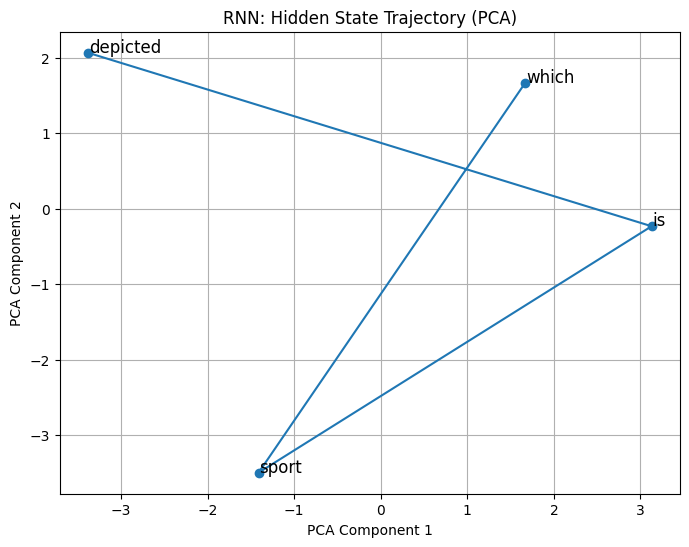

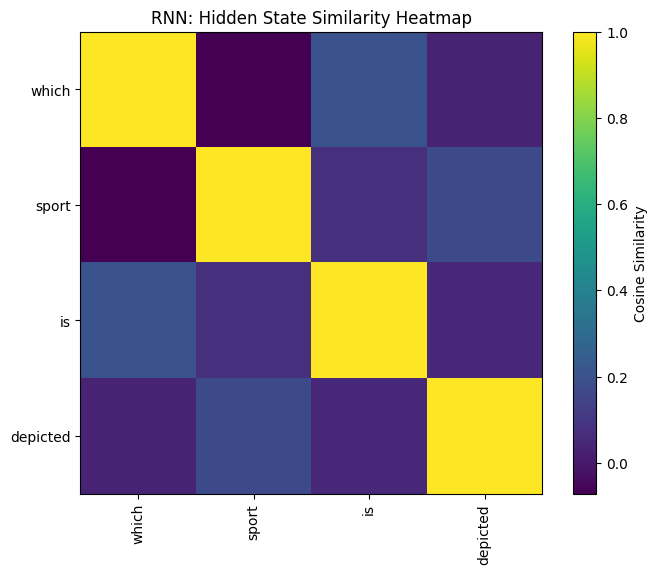

Plotting fusion similarity for all questions...


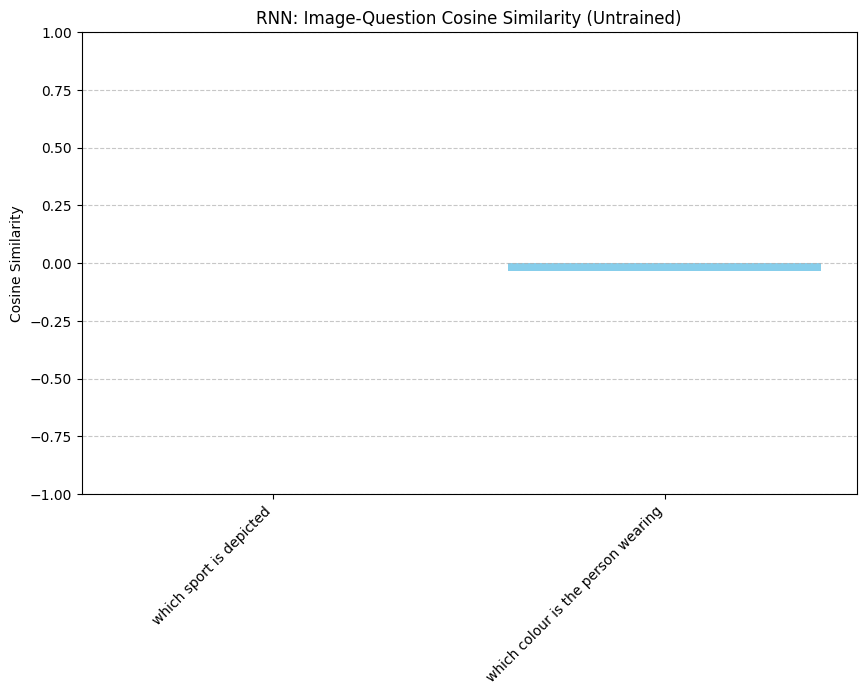


--- Analyzing LSTM ---
Plotting hidden state dynamics for: 'which sport is depicted'


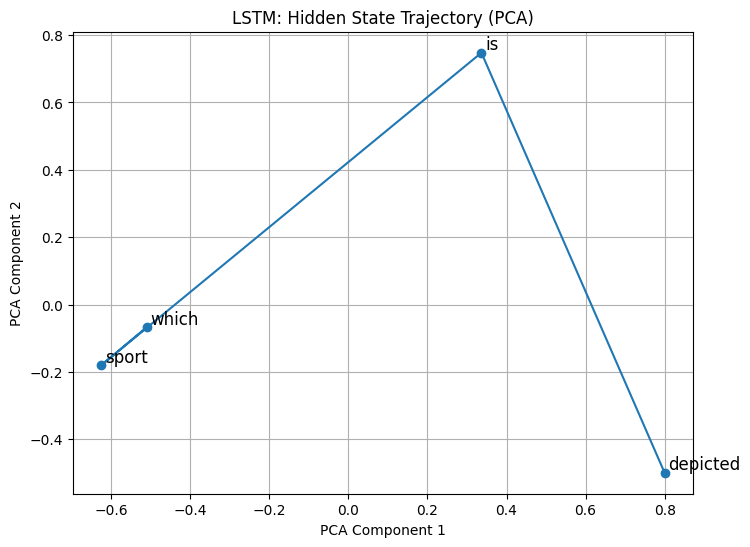

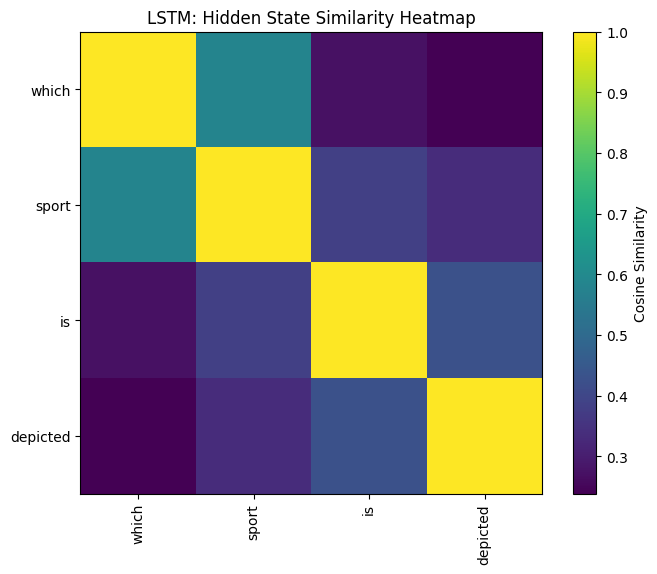

Plotting fusion similarity for all questions...


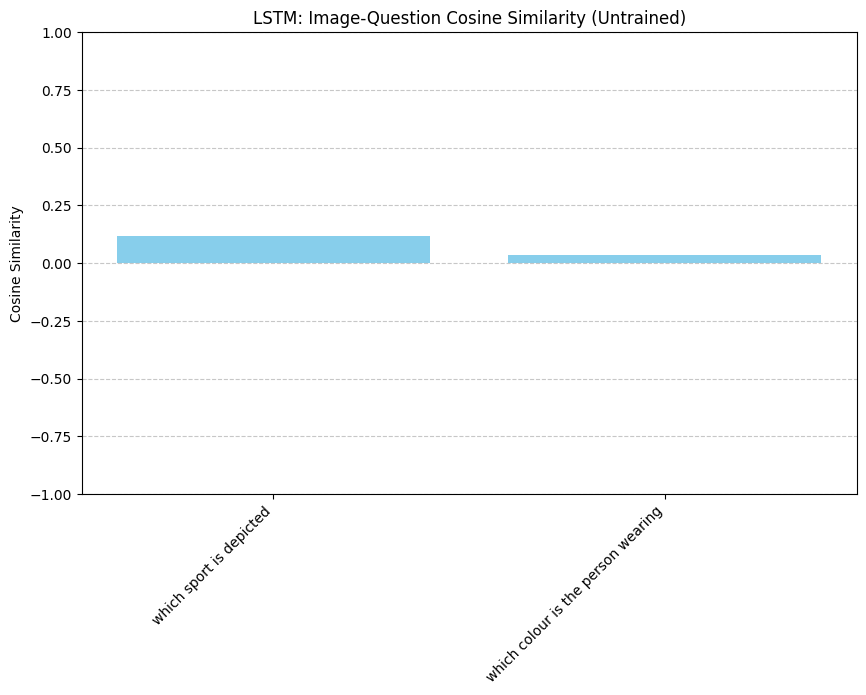


--- Analyzing GRU ---
Plotting hidden state dynamics for: 'which sport is depicted'


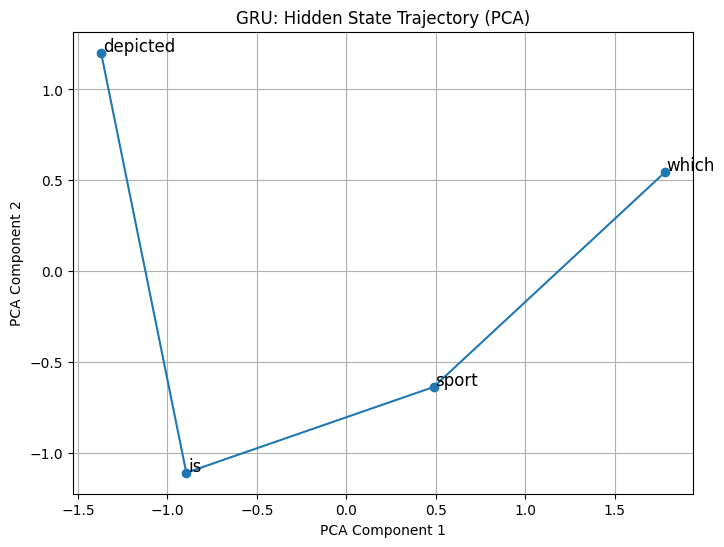

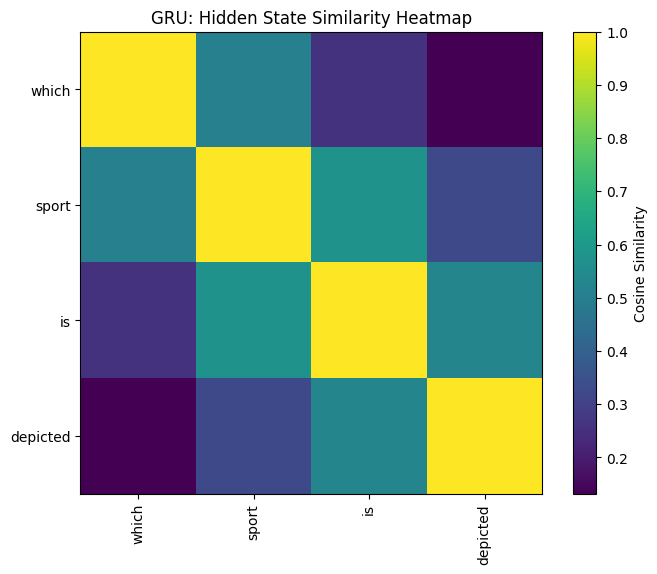

Plotting fusion similarity for all questions...


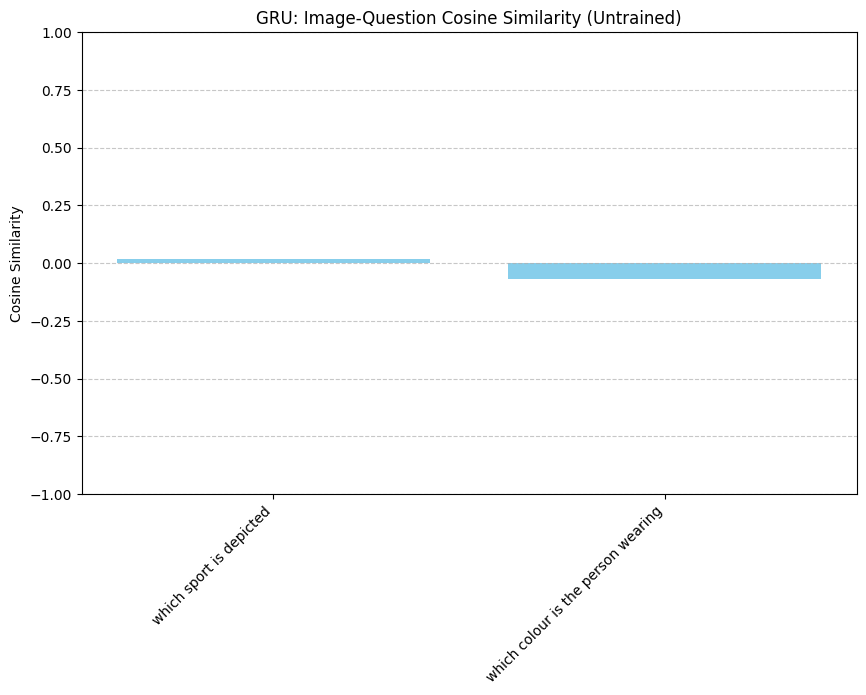

In [37]:
word_to_ix, vocab_size = build_vocab(QUESTIONS)
image_features = get_image_feature(IMAGE_URL)
sample_question_str = QUESTIONS[0]
sample_question_tokens = sample_question_str.split()
sample_question_tensor = question_to_tensor(sample_question_str, word_to_ix)
for model_name in ['RNN', 'LSTM', 'GRU']:
    print(f"\n--- Analyzing {model_name} ---")
    model = TextEncoder(model_name, vocab_size, EMBED_DIM, HIDDEN_DIM).to(DEVICE)
    model.eval()
    all_question_final_states = []
    sample_all_hidden_states = None
    with torch.no_grad():
        for q in QUESTIONS:
            q_tensor = question_to_tensor(q, word_to_ix)
            all_hidden, final_hidden = model(q_tensor)
            all_question_final_states.append(final_hidden)
            if q == sample_question_str:
                sample_all_hidden_states = all_hidden
        all_question_final_states = torch.stack(all_question_final_states)
    print(f"Plotting hidden state dynamics for: '{sample_question_str}'")
    plot_hidden_state_trajectory(sample_all_hidden_states, sample_question_tokens, model_name)
    plot_hidden_state_heatmap(sample_all_hidden_states, sample_question_tokens, model_name)
    print(f"Plotting fusion similarity for all questions...")
    plot_fusion_similarity(image_features, all_question_final_states, QUESTIONS, model_name)

RNN changes its hidden states quickly and forgets earlier words.
LSTM keeps past information better, so its changes are smoother.
GRU also remembers context like LSTM but updates a bit faster.
Overall, LSTM and GRU understand the question better than RNN.
